In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats

# import aesara.tensor as at

In [6]:
%matplotlib inline
rng = np.random.default_rng()

here's what we're going to do
1) simulate data from a linear gaussian process, y = ax + b
2) obtain the posterior using MCMC
3) approximate the posterior using VI

## 1. simulate data

$$ y_i \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = a_c + b_c * x_i; c \in \{0, 1\} $$
$$ \Rightarrow \mu_i = a_0*(1-c) + a_1*c + b_0*(1-c)*x_i + b_1*c * x_i; c \in \{0, 1\} $$


futher below we will define priors on each of these params

here we just set them to simulate a large dataset

In [9]:
# m is number of elements of c, i.e. 2
# n is number of samples

# a_vec mx1
# b_vec mx1
# c_vec nxm

# c_vec @ a_vec nx1
# c_vec @ b_vec nx1

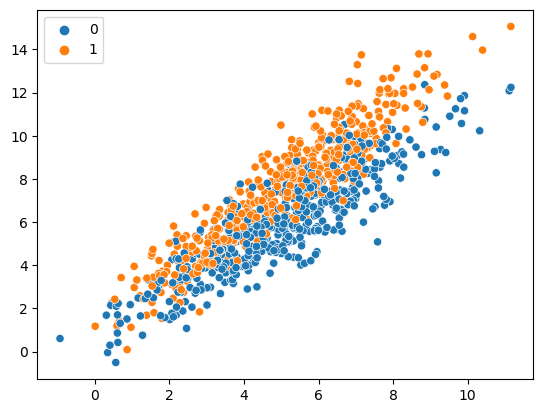

In [145]:
a_0 = 1
a_1 = 1.25
b_0 = 1
b_1 = 1.25
sigma = 1

n_obs = 1000
x_obs = rng.normal(5, 2, size=n_obs)
c_obs = rng.binomial(1, 0.5, size=n_obs)

xbar = np.mean(x_obs)

a_vec = np.array([a_0, a_1])
b_vec = np.array([b_0, b_1])
c_vec = np.zeros((len(c_obs), 2))
c_vec[np.arange(len(c_obs)), c_obs] = 1

mu_obs = c_vec @ a_vec + (c_vec @ b_vec) * x_obs

y_obs = rng.normal(mu_obs, sigma)

sns.scatterplot(x=x_obs, y=y_obs, hue=c_obs)
plt.show()

## 2. obtain the posterior using MCMC

In [ ]:
with pm.Model() as model:
    # priors
    sigma = pm.Uniform("s", 0, 10)
    a = pm.LogNormal("a", 0, 1, shape=2)
    b = pm.LogNormal("b", 0, 1, shape=2)

    # compute mu
    mu = a[c_obs] + b[c_obs] * (x_obs - xbar)

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=y_obs)

    trace = pm.sample()

       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
s     1.014  0.023   0.971    1.055      0.000      0.0    7610.0    3436.0   
a[0]  5.919  0.045   5.840    6.004      0.001      0.0    6261.0    3273.0   
a[1]  7.417  0.045   7.331    7.503      0.001      0.0    5342.0    3170.0   
b[0]  1.010  0.023   0.969    1.052      0.000      0.0    6177.0    3488.0   
b[1]  1.284  0.024   1.239    1.328      0.000      0.0    6107.0    3184.0   

      r_hat  
s       1.0  
a[0]    1.0  
a[1]    1.0  
b[0]    1.0  
b[1]    1.0  


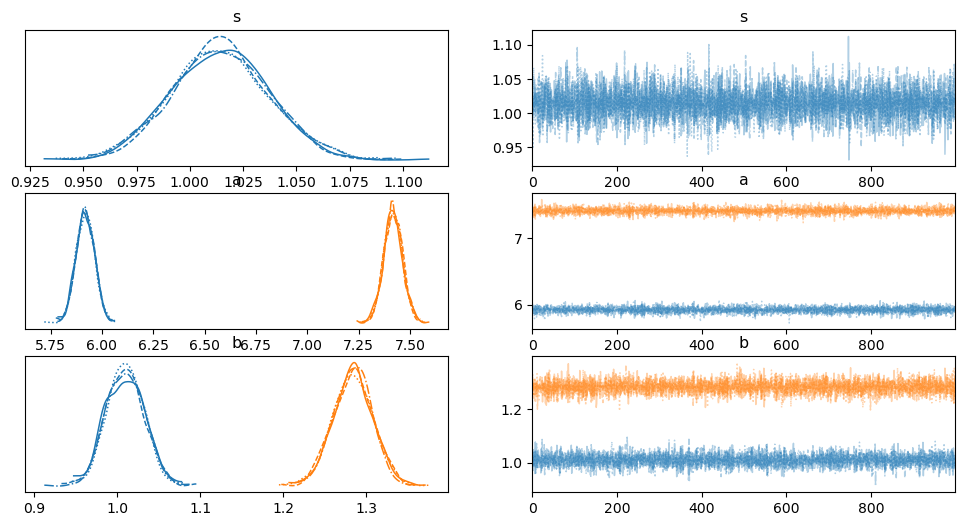

In [153]:
print(pm.summary(trace))
pm.plot_trace(trace)
plt.show()

## 3. approximate the posterior with mean-field VI

In variational inference we use a family of pre-defined probability distributions Q, over our hidden variables, and attempt to minimize the KL divergence between our selected distribution q(z) and our true posterior p(z|x)

$ q^*(z) = \operatorname*{argmin}_{q(z) \in Q}( KL(q(z), p(z|x) )$

$ = \operatorname*{argmax}_{q(z)}(ELBO) $

where

$ ELBO(q) = \int_z [\log p(x, z) - \log q(z)]dz $

This is computationally more tractable when we assume that each $z_k$ is independent and gives us the following function for each $q(z_k)$

$ ELBO_k = \int q(z_k)E_{\_k}[log p(z_k | z_{\_k}, x)]dz_k − \int q(z_k) log q(z_k)dz_k $

taking the derivative with respect to $q(z_k)$ gives us the update step for each $q(z_k)$

$ q^*(z_k) \propto exp\{E_{\_k}[log p(z_k, Z_{\_k}, x)]\} $

In [154]:
with model:
    advi_fit = pm.fit(method=pm.ADVI(), n=30000)

Finished [100%]: Average Loss = 1,456.9


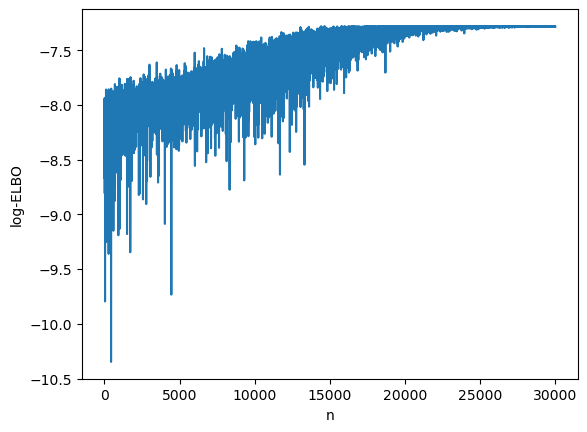

In [159]:
advi_elbo = pd.DataFrame(
    {"log-ELBO": -np.log(advi_fit.hist), "n": np.arange(advi_fit.hist.shape[0])}
)

sns.lineplot(y="log-ELBO", x="n", data=advi_elbo)
plt.show()

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
s,1.013,0.026,0.967,1.062,0.000,0.0,10096.0,9812.0,NaN
a[0],5.922,0.055,5.823,6.027,0.001,0.0,10212.0,9711.0,NaN
a[1],7.422,0.060,7.316,7.542,0.001,0.0,9992.0,9944.0,NaN
b[0],1.008,0.025,0.961,1.054,0.000,0.0,10406.0,9877.0,NaN
b[1],1.283,0.026,1.237,1.334,0.000,0.0,9391.0,9127.0,NaN


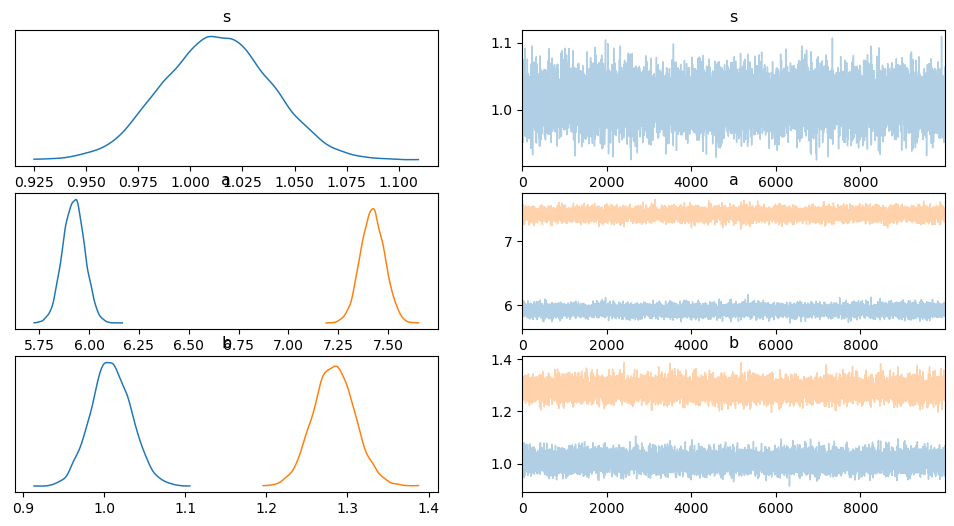

In [160]:
advi_trace = advi_fit.sample(10000)
pm.plot_trace(advi_trace)
pm.summary(advi_trace)